## repeataly

**predicting repeat customers with sales data**

zen yui | 2016-03-05

### notes:
- k-means to segment
- logistic regression for feature selection
- random forest for prediction

In [91]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from __future__ import division
from datetime import date
%matplotlib inline

In [2]:
# use ggplot style
plt.style.use('ggplot')

### read data from source csv

In [92]:
# read data in from csv
df_read = pd.read_csv('eataly_data.csv')

In [137]:
# copy dataframe so we don't edit original file data
df = df_read.copy()

### feature engineering in pandas

In [138]:
# drop customer visit and visit key, as it cannot be used for analysis
df.drop(['CustomerKey','VisitNumber'], axis=1, inplace=True)

In [139]:
# convert TicketDate to datetime type
df['TicketDate'] = pd.to_datetime(df['TicketDate'])

In [140]:
#convert 'TicketTime' to continuous integer
TimeList = df['TicketTime'].str.split(':')
df['TicketTime'] = TimeList.str[0].astype(float) + TimeList.str[1].astype(float) / 60.0

In [156]:
#get weekday number (1=Monday ... 7=Sunday)
df['WeekdayNumber'] = df['TicketDate'].apply(lambda x: x.isoweekday())

In [151]:
# Binary flag for a weekday visit
df['IsWeekday'] = df['WeekdayNumber'] < 6

In [144]:
#create "isFrontEnd" feature, drop 'StationGroup'
df['IsFrontEnd'] = df['StationGroup'] == 'Front End'
df.drop('StationGroup',axis=1,inplace=True)

In [145]:
df.shape

(1621854, 18)

In [251]:
# sample data, transposed for readability
df.sample(5).T

,983117,150760,1578881,369930,567135
TicketDate,2015-07-11 00:00:00,2014-07-13 00:00:00,2014-04-20 00:00:00,2014-10-06 00:00:00,2015-01-09 00:00:00
TicketTime,15.7667,16.1833,12.7667,20.7167,20.5833
PriorVisits,0,0,2,0,0
SaleLines,1,4,3,4,3
ReturnLines,0,0,0,0,0
GiftCardLines,0,0,0,0,0
NetAmount,7.16,17.79,8.4,8.26,23.58
NetRetailAmount,0,17.79,8.4,8.26,23.58
NetQSRAmount,7.16,0,0,0,0
DiscountAmount,0,0,0,0,0


In [152]:
df.dtypes

TicketDate          datetime64[ns]
TicketTime                 float64
PriorVisits                  int64
SaleLines                    int64
ReturnLines                  int64
GiftCardLines                int64
NetAmount                  float64
NetRetailAmount            float64
NetQSRAmount               float64
DiscountAmount             float64
UniqueItems                  int64
UniqueCategories             int64
ReturnedBags                  bool
BoughtProduce                 bool
WillReturn                    bool
WeekdayNumber                int64
IsWeekday                     bool
IsFrontEnd                    bool
dtype: object

### get the overall rate repeat visits

In [118]:
'Overall tickets yielding repeat business: {:.2f}%'.format(df.WillReturn.mean()*100)

'Overall tickets yielding repeat business: 44.46%'

### split data into test/train sets

In [120]:
# separate the data set into features and prediction
X = df.drop('WillReturn',axis=1).copy()
y = df['WillReturn']

In [250]:
X.head().T

,0,1,2,3,4
TicketDate,2014-05-10 00:00:00,2014-05-10 00:00:00,2014-05-10 00:00:00,2014-05-10 00:00:00,2014-05-10 00:00:00
TicketTime,11.7833,11.9,12.0667,12.0833,12.1
PriorVisits,0,3,1,0,1
SaleLines,1,2,3,2,2
ReturnLines,0,0,0,0,0
GiftCardLines,0,0,0,0,0
NetAmount,3.2,53,44.6,38.4,14.4
NetRetailAmount,0,0,9.6,0,0
NetQSRAmount,3.2,53,35,38.4,14.4
DiscountAmount,0,0,0,0,0


In [129]:
d = date(2016,3,7)
d.isoweekday()

1

### EDA on features

### define two EDA helper functions

In [245]:
# define function 'get_rrate' for quick analysis of features and repeat business
def get_rrate(df, col_list):
    """Given a dataframe and list of groupby columns,
    return a crosstab dataframe of Repeat, NonRepeat, and RepeatRate
    """
    rdict = {1:'Repeat',0:'NonRepeat'}
    rorder = ['Repeat','NonRepeat']

    ct = pd.crosstab([df[c] for c in col_list], df['WillReturn'].map(rdict))[rorder]
    ct['CustCount'] = ct['Repeat'] + ct['NonRepeat']
    ct['CustDist'] = ct['CustCount'].astype(float) / ct['CustCount'].sum() * 100
    ct['RepeatRate'] = ct['Repeat'].astype(float) / ct['CustCount'] * 100
    ct['RepeatDist'] = ct['Repeat'].astype(float) / ct['Repeat'].sum() * 100
    ct.columns.name=None
    return ct

In [246]:
def plot_rrate(df, col_list):
    """Given dataframe and list of columns, call "get_rrate" to
    calculate return-rate distributions by feature values,
    then plot the rate of return and % return rate
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ct = get_rrate(df, col_list)
    ct[['Repeat','NonRepeat']].plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, ax=axes[0])
    axes[0].set_title('returns per ' + ', '.join(col_list))
    axes[0].set_ylabel('Customer Count')
    
    ct[['RepeatRate']].plot(kind='bar', stacked=True, color=['k'], alpha=.5, ax=axes[1], ylim=(0,100))
    axes[1].set_title('return rate by ' + ', '.join(col_list))
    axes[1].set_ylabel('% Return Rate')

### impact of weekdays on return visits
- Traffic seems equally distributed between days of the week
- More repeat customers shop on weekdays in number and percentage

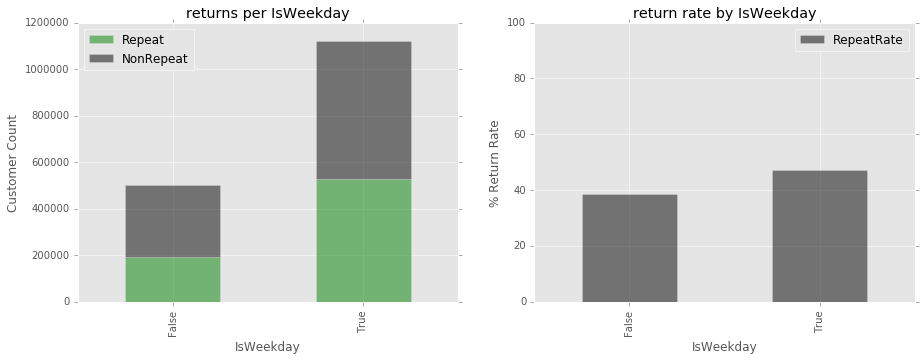

In [247]:
plot_rrate(df, ['IsWeekday'])

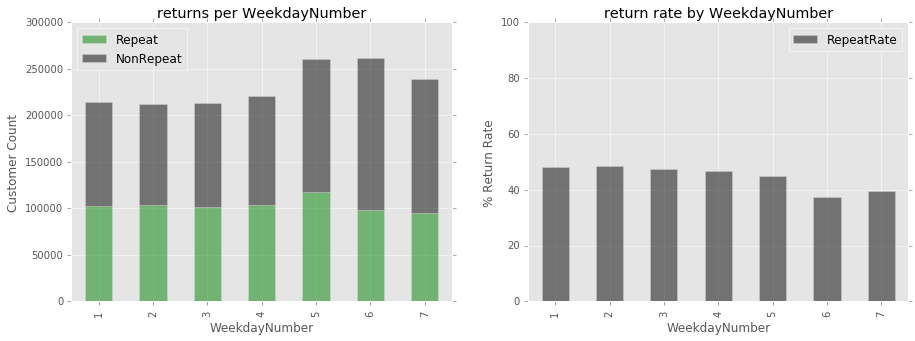

In [248]:
plot_rrate(df, ['WeekdayNumber'])